# Working with Tensorforce to Train a Reinforcement-Learning Agent

This notebook serves as an educational introduction to the usage of Tensorforce using a gym-electric-motor (GEM) environment. The goal of this notebook is to give an understanding of what tensorforce is and how to use it to train and evaluate a reinforcement learning agent that can solve a current control problem of the GEM toolbox.


## 1. Installation

Before you can start you need to make sure that you have both gym-electric-motor and tensorforce installed. You can install both easily using pip:

  - ```pip install gym-electric-motor```
  - ```pip install tensorforce```

Alternatively, you can install their latest developer version directly from GitHub:

  - [GitHub Gym-Electric-Motor](https://github.com/upb-lea/gym-electric-motor)
  - [GitHub Tensorforce](https://github.com/tensorforce/tensorforce)

For this notebook, the following cell will do the job:

In [1]:
!pip install -q git+https://github.com/upb-lea/gym-electric-motor.git tensorforce==0.5.5

In [2]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

## 2. Setting up a GEM Environment

The basic idea behind reinforcement learning is to create a so-called agent, that should learn by itself to solve a specified task in a given environment. 
This environment gives the agent feedback on its actions and reinforces the targeted behavior.
In this notebook, the task is to train a controller for the current control of a *permanent magnet synchronous motor* (*PMSM*).
 
In the following, the used GEM-environment is briefly presented, but this notebook does not focus directly on the detailed usage of GEM. If you are new to the used environment and interested in finding out what it does and how to use it, you should take a look at the [GEM cookbook](https://colab.research.google.com/github/upb-lea/gym-electric-motor/blob/master/examples/example_notebooks/GEM_cookbook.ipynb).

The basic idea of the control setup from the GEM-environment is displayed in the following figure. 

![](../../docs/plots/SCML_Overview.png)

The agent controls the converter who converts the supply currents to the currents flowing into the motor - for the *PMSM*: $i_{sq}$ and $i_{sd}$

In the continuous case, the agent's action equals a duty cycle which will be modulated into a corresponding voltage. 

In the discrete case, the agent's actions denote switching states of the converter at the given instant. Here, only a discrete amount of options are available. In this notebook, for the PMSM the *discrete B6 bridge converter* with six switches is utilized per default. This converter provides a total of eight possible actions.

![](../../docs/plots/B6.svg)

The motor schematic is the following:


![](../../docs/plots/ESBdq.svg)

And the electrical ODEs for that motor are:

<h3 align="center">

<!-- $\frac{\mathrm{d}i_{sq}}{\mathrm{d}t} = \frac{u_{sq}-pL_d\omega_{me}i_{sd}-R_si_{sq}}{L_q}$

$\frac{\mathrm{d}i_{sd}}{\mathrm{d}t} = \frac{u_{sd}-pL_q\omega_{me}i_{sq}-R_si_{sd}}{L_d}$

$\frac{\mathrm{d}\epsilon_{el}}{\mathrm{d}t} = p\omega_{me}$
 -->

   $ \frac{\mathrm{d}i_{sd}}{\mathrm{d}t}=\frac{u_{sd} + p\omega_{me}L_q i_{sq} - R_s i_{sd}}{L_d} $ <br><br>
    $\frac{\mathrm{d} i_{sq}}{\mathrm{d} t}=\frac{u_{sq} - p \omega_{me} (L_d i_{sd} + \mathit{\Psi}_p) - R_s i_{sq}}{L_q}$ <br><br>
   $\frac{\mathrm{d}\epsilon_{el}}{\mathrm{d}t} = p\omega_{me}$

</h3>

The target for the agent is now to learn to control the currents. For this, a reference generator produces a trajectory that the agent has to follow. 
Therefore, it has to learn a function (policy) from given states, references and rewards to appropriate actions.

For a deeper understanding of the used models behind the environment see the [documentation](https://upb-lea.github.io/gym-electric-motor/).
Comprehensive learning material to RL is also [freely available](https://github.com/upb-lea/reinforcement_learning_course_materials).

In [3]:
import numpy as np
from pathlib import Path
import gym_electric_motor as gem
from gym_electric_motor.reference_generators import \
    MultipleReferenceGenerator,\
    WienerProcessReferenceGenerator
from gym_electric_motor.visualization import MotorDashboard
from gym_electric_motor.core import Callback
from gym.spaces import Discrete, Box
from gym.wrappers import FlattenObservation, TimeLimit
from gym import ObservationWrapper

/home/wilhelmk/tools/anaconda3/envs/tf-cpu/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [4]:
# helper functions and classes

class FeatureWrapper(ObservationWrapper):
    """
    Wrapper class which wraps the environment to change its observation. Serves
    the purpose to improve the agent's learning speed.
    
    It changes epsilon to cos(epsilon) and sin(epsilon). This serves the purpose
    to have the angles -pi and pi close to each other numerically without losing
    any information on the angle.
    
    Additionally, this wrapper adds a new observation i_sd**2 + i_sq**2. This should
    help the agent to easier detect incoming limit violations.
    """

    def __init__(self, env, epsilon_idx, i_sd_idx, i_sq_idx):
        """
        Changes the observation space to fit the new features
        
        Args:
            env(GEM env): GEM environment to wrap
            epsilon_idx(integer): Epsilon's index in the observation array
            i_sd_idx(integer): I_sd's index in the observation array
            i_sq_idx(integer): I_sq's index in the observation array
        """
        super(FeatureWrapper, self).__init__(env)
        self.EPSILON_IDX = epsilon_idx
        self.I_SQ_IDX = i_sq_idx
        self.I_SD_IDX = i_sd_idx
        new_low = np.concatenate((self.env.observation_space.low[
                                  :self.EPSILON_IDX], np.array([-1.]),
                                  self.env.observation_space.low[
                                  self.EPSILON_IDX:], np.array([0.])))
        new_high = np.concatenate((self.env.observation_space.high[
                                   :self.EPSILON_IDX], np.array([1.]),
                                   self.env.observation_space.high[
                                   self.EPSILON_IDX:],np.array([1.])))

        self.observation_space = Box(new_low, new_high)

    def observation(self, observation):
        """
        Gets called at each return of an observation. Adds the new features to the
        observation and removes original epsilon.
        
        """
        cos_eps = np.cos(observation[self.EPSILON_IDX] * np.pi)
        sin_eps = np.sin(observation[self.EPSILON_IDX] * np.pi)
        currents_squared = observation[self.I_SQ_IDX]**2 + observation[self.I_SD_IDX]**2
        observation = np.concatenate((observation[:self.EPSILON_IDX],
                                      np.array([cos_eps, sin_eps]),
                                      observation[self.EPSILON_IDX + 1:],
                                      np.array([currents_squared])))
        return observation

In [5]:
# define motor arguments
motor_parameter = dict(
    p=3,  # [p] = 1, nb of pole pairs
    r_s=17.932e-3,  # [r_s] = Ohm, stator resistance
    l_d=0.37e-3,  # [l_d] = H, d-axis inductance
    l_q=1.2e-3,  # [l_q] = H, q-axis inductance
    psi_p=65.65e-3,  # [psi_p] = Vs, magnetic flux of the permanent magnet
)
# supply voltage
u_supply = 350

# nominal and absolute state limitations
nominal_values=dict(
    omega=4000*2*np.pi/60,
    i=230,
    u=u_supply
)
limit_values=dict(
    omega=4000*2*np.pi/60,
    i=1.5*230,
    u=u_supply
)

# sampling interval
tau = 1e-5

# define maximal episode steps
max_eps_steps = 10000


motor_initializer={'random_init': 'uniform', 'interval': [[-230, 230], [-230, 230], [-np.pi, np.pi]]}
reward_function=gem.reward_functions.WeightedSumOfErrors(
    reward_weights={'i_sq': 10, 'i_sd': 10},
    gamma=0.99,  # discount rate 
    reward_power=1
)


# creating gem environment
env = gem.make(  # define a PMSM with discrete action space
    "Finite-CC-PMSM-v0",
    # visualize the results
    visualization=MotorDashboard(state_plots=['i_sq', 'i_sd'], reward_plot=True),
    
    # parameterize the PMSM and update limitations
    motor=dict(
        motor_parameter=motor_parameter,
        limit_values=limit_values,
        nominal_values=nominal_values,
        motor_initializer=motor_initializer,
    ),
    # define the random initialisation for load and motor
    load=dict(
        load_initializer={'random_init': 'uniform', },
    ),
    reward_function=reward_function,
    supply=dict(u_sup=u_supply),
    # define the duration of one sampling step
    tau=tau,
    
    ode_solver='euler',
)

# remove one action from the action space to help the agent speed up its training
# this can be done as both switchting states (1,1,1) and (-1,-1,-1) - which are encoded
# by action 0 and 7 - both lead to the same zero voltage vector in alpha/beta-coordinates
env.action_space = Discrete(7)

# applying wrappers
eps_idx = env.physical_system.state_names.index('epsilon')
i_sd_idx = env.physical_system.state_names.index('i_sd')
i_sq_idx = env.physical_system.state_names.index('i_sq')
env = TimeLimit(
    FeatureWrapper(
        FlattenObservation(env), 
        eps_idx, i_sd_idx, i_sq_idx
    ),
    max_eps_steps
)

## 3. Using Tensorforce

To take advantage of some already implemented deep-RL agents, we use the *tensorforce-framework*. It is built on *TensorFlow* and offers agents based on deep Q-networks, policy gradients, or actor-critic algorithms. 

For more information to specific agents or different modules that can be used, some good explanations can be found in the corresponding [documentation](https://tensorforce.readthedocs.io/en/latest/).
   
For the control task with a discrete action space we will use a [deep Q-network (DQN)]((https://www.nature.com/articles/nature14236)).

### 3.1 Defining a Tensorforce-Environment

Tensorforce requires you to define a *tensorforce-environment*. This is done simply by using the ```Environment.create``` interface, which acts as a wrapper around usual [gym](https://github.com/openai/gym) instances.

In [6]:
from tensorforce.environments import Environment

# creating tensorforce environment
tf_env = Environment.create(environment=env,
                            max_episode_timesteps=max_eps_steps)

### 3.2 Setting-up a Tensorforce-Agent

The Agent is created just like the environment. The agent's parameters can be passed as arguments to the ```create()``` function or via a configuration as a dictionary or as *.json* file.
In the following, the way via a dictionary is demonstrated.

With the *tensorforce-framework* it is possible to define own network-architectures like it is shown below.
For some parameters, it can be useful to have a decaying value during the training. A possible way for this is also shown in the following code.

The exact meaning of the used parameters can be found in the already mentioned tensorforce documentation.


In [7]:
# using a parameter decay for the exploration
epsilon_decay = {'type': 'decaying',
                 'decay': 'polynomial',
                 'decay_steps': 50000,
                 'unit': 'timesteps',
                 'initial_value': 1.0,
                 'decay_rate': 5e-2,
                 'final_value': 5e-2,
                 'power': 3.0}

# defining a simple network architecture: 2 dense-layers with 64 nodes each
net = [
    dict(type='dense', size=64, activation='relu'),
    dict(type='dense', size=64, activation='relu'),
]

# defining the parameters of a dqn-agent
agent_config = {
    'agent': 'dqn',
    'memory': 200000,
    'batch_size': 25,
    'network': net,
    'update_frequency': 1,
    'start_updating': 10000,
    'learning_rate': 1e-4,
    'discount': 0.99,
    'exploration': epsilon_decay,
    'target_sync_frequency': 1000,
    'target_update_weight': 1.0,
    }

In [8]:
from tensorforce.agents import Agent

tau = 1e-5
simulation_time = 2 # seconds
training_steps = int(simulation_time // tau)
# creating agent via dictionary
dqn_agent = Agent.create(agent=agent_config, environment=tf_env)

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


### 3.3 Training the Agent

Training the agent is executed with the **tensorforce-runner**. The runner stores metrics during the training, like the reward per episode, and can be used to save learned agents. If you just want to experiment a little with an already trained agent, it is possible to skip the next cells and just load a pre-trained agent.

In [9]:
from tensorforce.execution import Runner

# create and train the agent
runner = Runner(agent=dqn_agent, environment=tf_env)
runner.run(num_timesteps=training_steps)

Timesteps:  95%|█████████▌| 190670/199999 [11:20<00:32, 286.56it/s, mean_reward=n/a]

Accessing saved metrics from the runner, it is possible to have a look on the mean reward per episode or the corresponding episode-length. 

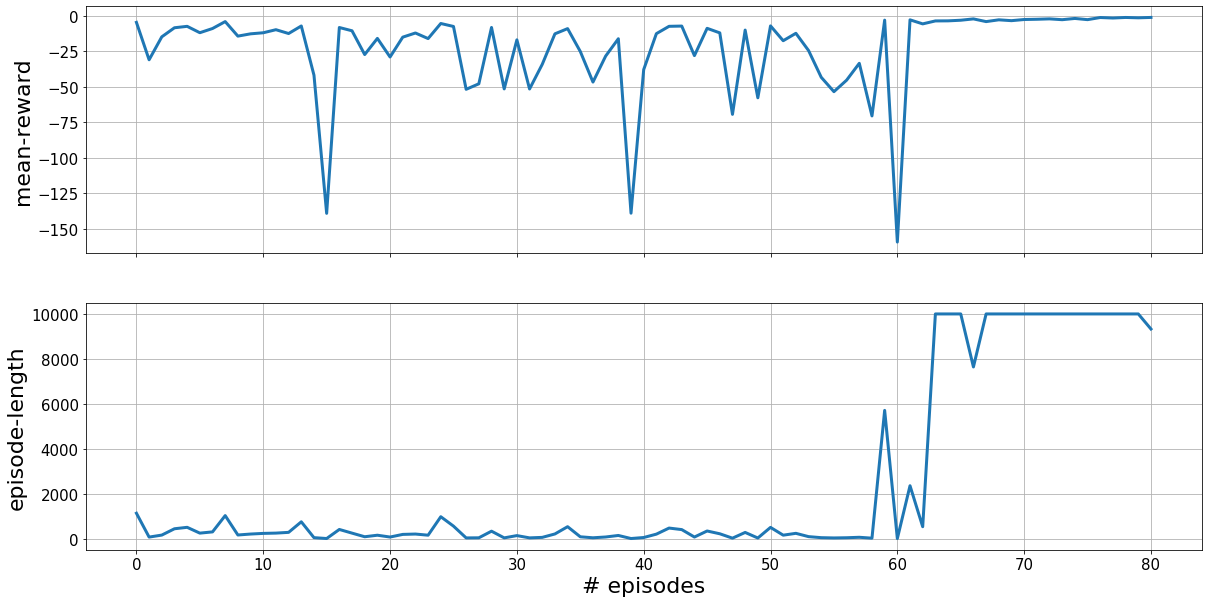

number of episodes during training:  81


In [10]:
# accesing the metrics from runner
rewards = np.asarray(runner.episode_rewards)
episode_length = np.asarray(runner.episode_timesteps)

# calculating the mean-reward per episode
mean_reward = rewards/episode_length
num_episodes = len(mean_reward)

# plotting mean-reward over episodes
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(20,10))
ax1.plot(range(num_episodes), mean_reward, linewidth=3)
#plt.xticks(fontsize=15)
ax1.set_ylabel('mean-reward', fontsize=22)
ax1.grid(True)
ax1.tick_params(axis="y", labelsize=15) 
# plotting episode length over episodes
ax2.plot(range(num_episodes), episode_length, linewidth=3)
ax2.set_xlabel('# episodes', fontsize=22)
ax2.set_ylabel('episode-length', fontsize=22)
ax2.tick_params(axis="y", labelsize=15) 
ax2.tick_params(axis="x", labelsize=15) 
ax2.grid(True)

plt.show()

print('number of episodes during training: ', len(rewards))

Saving the agents trained model makes it available for a separate evaluation and further usage.

In [11]:
agent_path = Path('saved_agents')
agent_path.mkdir(parents=True, exist_ok=True)
agent_name = 'dqn_agent_tensorforce'
runner.agent.save(directory=str(agent_path), filename=agent_name)
print('\n agent saved \n')
runner.close()

Instructions for updating:
Use `tf.compat.v1.graph_util.remove_training_nodes`
Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


Timesteps:  95%|█████████▌| 190670/199999 [11:36<00:34, 273.67it/s, mean_reward=n/a]


 agent saved 



## 4. Evaluating the Trained Agent

### 4.1 Loading a Model

If a previously saved agent is available, it can be restored by using the runner to load the model with the ```load()``` function. To load the agent it is necessary to pass the directory, the filename, the environment, and the agent configuration used for the training.

In [12]:
from tensorforce import Agent

dqn_agent = Agent.load(
    directory=str(agent_path),
    filename=agent_name,
    environment=tf_env,
    **agent_config
)
print('\n agent loaded \n')

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Restoring parameters from saved_agents/dqn_agent_tensorforce

 agent loaded 



### 4.3 Evaluating the Agent

To use the trained agent as a controller, a typical loop to interact with the environment can be used, which is displayed in the cell below.

Now the agent takes the observations from the environment and reacts with an action, which is used to control the environment. To get an impression of how the trained agent performs, the trajectory of the control-states can be observed. A live-plot will be displayed in a jupyter-notebook. If you are using jupyter-lab, the following cell could cause problems regarding the visualization.

<IPython.core.display.Javascript object>


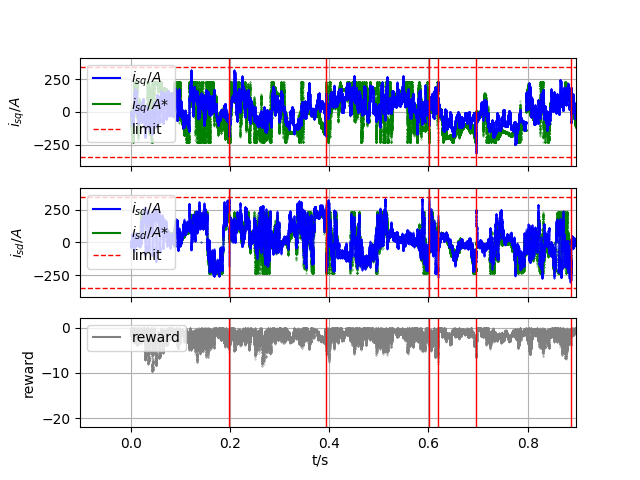

In [13]:
%matplotlib notebook

# currently the visualization crashes for larger values, than the defined value
visualization_steps = int(9e4) 
obs = env.reset()
for step in range(visualization_steps):
    # getting the next action from the agent
    actions = dqn_agent.act(obs, evaluation=True)
    # the env return the next state, reward and the information, if the state is terminal
    obs, reward, done, _ = env.step(action=actions)
    # activating the visualization
    env.render()

    if done:
        # reseting the env, if a terminal state is reached
        obs = env.reset()


In the next example a classic *environment-interaction loop* can be extended to access different metrics and values, e.g. the cumulated reward over all steps. The number of evaluation-steps can be reduced, but a higher variance of the evaluation result must then be accepted.

In [14]:
# test agent
steps = 250000

rewards = []
episode_lens = []

obs = env.reset()
terminal = False
cumulated_rew = 0
step_counter = 0
episode_rew = 0

for step in (range(steps)):
    actions = dqn_agent.act(obs, evaluation=True)
    obs, reward, done, _ = env.step(action=actions)
    
    cumulated_rew += reward
    episode_rew += reward
    
    step_counter += 1

    if done:
        rewards.append(episode_rew)
        episode_lens.append(step_counter)
        episode_rew = 0
        step_counter = 0
        
        obs = env.reset()
        done = False

print(f' \n Cumulated reward per step is {cumulated_rew/steps} \n')
print(f' \n Number of episodes Reward {len(episode_lens)} \n')




 
 Cumulated reward per step is -1.9074805558363808 

 
 Number of episodes Reward 41 



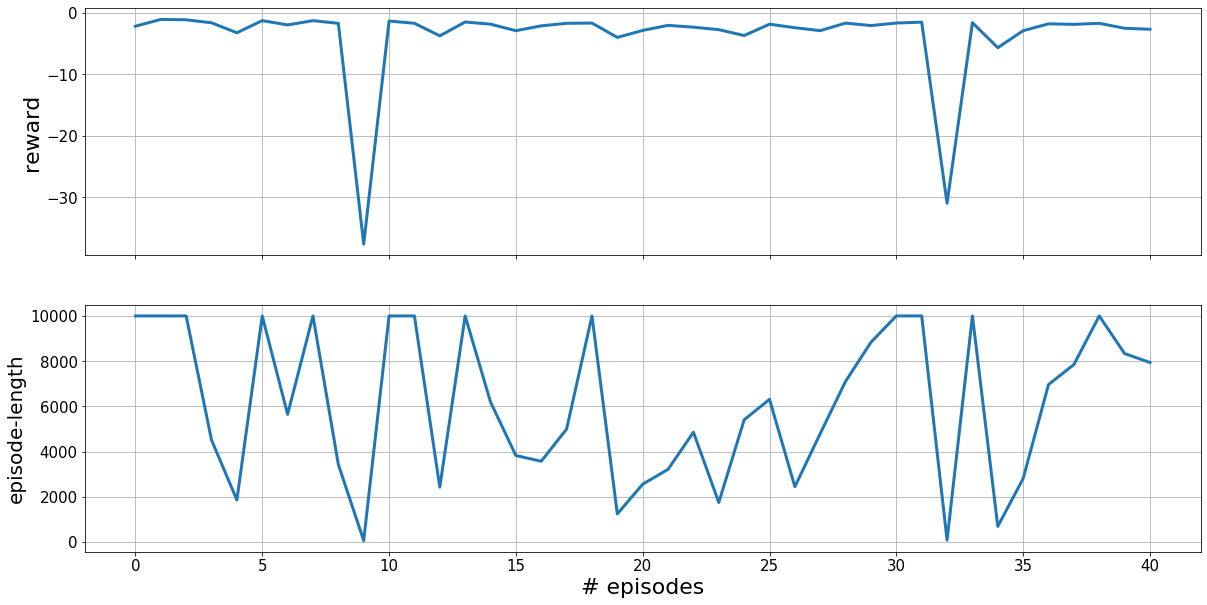

number of episodes during training:  41


In [15]:
%matplotlib inline
# accesing the metrics from runner
rewards = np.asarray(rewards)
episode_length = np.asarray(episode_lens)
# calculating the mean-reward per episode
mean_reward = rewards/episode_length
num_episodes = len(rewards)

# plotting mean-reward over episodes
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(20, 10))
ax1.plot(range(num_episodes), mean_reward, linewidth=3)
#plt.xticks(fontsize=15)
ax1.set_ylabel('reward', fontsize=22)
ax1.grid(True)
ax1.tick_params(axis="y", labelsize=15) 
# plotting episode length over episodes
ax2.plot(range(num_episodes), episode_length, linewidth=3)
ax2.set_xlabel('# episodes', fontsize=22)
ax2.set_ylabel('episode-length', fontsize=20)
ax2.tick_params(axis="y", labelsize=15) 
ax2.tick_params(axis="x", labelsize=15) 

ax2.grid(True)

plt.show()

print('number of episodes during training: ', len(episode_lens))